In [1]:
%load_ext cython
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=64'
import cbclib as cbc
import numpy as np
import pandas as pd
import pyximport
from importlib import reload
import sys
import hdf5plugin
import h5py
import pygmo
import matplotlib.animation as animation
from tqdm.auto import tqdm
from scipy import ndimage
from scipy.optimize import minimize, differential_evolution
from scipy.interpolate import interpn

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider
from pickle import load, dump

pyximport.install(reload_support=True, build_in_temp=False,
                  build_dir='.pyxbld')

(None, <pyximport._pyximport3.PyxImportMetaFinder at 0x2ba9b2f88ac0>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__test__', 'det_to_k', 'det_to_k_vjp', 'k_to_det', 'k_to_det_vjp', 'k_to_smp', 'k_to_smp_vjp', 'np', 'source_lines', 'source_lines_vjp']


In [ ]:
basis = np.array([[-0.00093604, -0.00893389, -0.00049815],
                  [0.00688718, -0.00039195, -0.00573877],
                  [0.01180108, -0.00199115,  0.01430421]])
kmin = np.array([0.00876745, 0.00437237, 0.99995201])
kmax = np.array([0.03538482, 0.03246592, 0.99884627])
hkl = np.array([[ -8,  18,   5],
                [ 24,   4,   1],
                [  6, -12,  -5],
                [ -4,  -2,  -1],
                [ 17,  15,   5],
                [-19,  -3,  -3],
                [  0,  -7,  -3],
                [ 24,  -6,  -3],
                [ 16,  20,   6],
                [ -1,   9,   3]])
hkl = np.tile(hkl, (10, 1))

%time kin = dev.source_lines(hkl=hkl, basis=basis.ravel(), kmin=kmin, kmax=kmax)[0]
%time kin2 = cbc.src.source_lines(hkl=hkl, basis=basis, kmin=kmin[:2], kmax=kmax[:2])[0]

np.isclose(np.sort(kin, axis=1), np.sort(kin2, axis=1))

In [ ]:
from scipy.optimize import approx_fprime

f = lambda x: cbc.bin.calc_source_lines(hkl=hkl, basis=x.reshape((3, 3)), kin_min=kmin, kin_max=kmax)[0].ravel()
grad = approx_fprime(basis, f, epsilon=1e-8).reshape(kin.shape + (9,))

In [ ]:
np.sum(vec[..., None] * grad, axis=(0, 1, 2))

## Lysozyme June 2021

In [4]:
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))
setup = cbc.ScanSetup.read('results/Lysozyme_June_2021/exp_geom_232_ref_2.ini')

scan_num = 232
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(input_file=cbc.CXIStore(h5_files), transform=crop)

In [2]:
input_file = cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5')
input_file.update()
input_file.indices['whitefield']

array([['results/Lysozyme_June_2021/scan_250_whitefield.h5',
        '/entry/crystallography/whitefield', ()]], dtype=object)

In [5]:
wf_data = cbc.CrystData(input_file=cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5'),
                        transform=crop).load('whitefield')

In [4]:
idxs = np.arange(0, 300, 5)

data = data.clear().load(idxs=idxs)

Loading data:   0%|          | 0/60 [00:00<?, ?it/s]

In [8]:
x0, y0 = crop.forward_points(x=setup.pupil_roi[2], y=setup.pupil_roi[0])
x1, y1 = crop.forward_points(x=setup.pupil_roi[3], y=setup.pupil_roi[1])
pad = 40
roi = (int(y0) - pad, int(y1) + pad, int(x0) - pad, int(x1) + pad)

In [9]:
data = data.reset_mask()
data = data.update_mask(method='range', vmax=10000000)
data = data.update_whitefield(method='robust-mean')
data = data.update_std(method='poisson')

In [10]:
data = data.scale_whitefield(method='median')

In [11]:
data = data.update_snr()
data = data.import_mask(data.whitefield < 50.0, update='multiply')
data = data.update_snr()

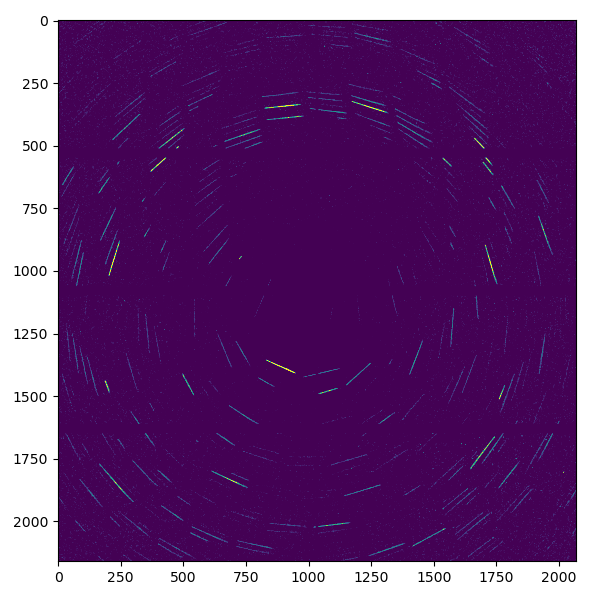

In [12]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(data.snr[1], vmin=0, vmax=5)
fig.tight_layout()
plt.show()

In [13]:
det_obj = data.line_detector(cbc.src.Structure(4, 3))

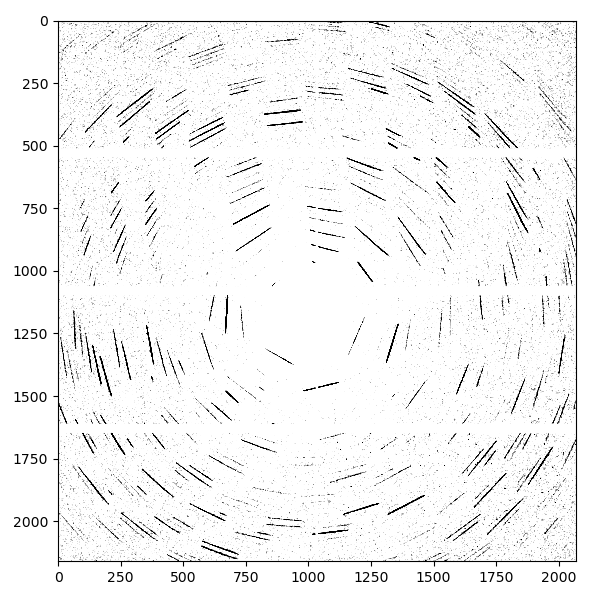

In [14]:
%matplotlib widget

index = 0

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(det_obj.data[index], vmin=0.0, vmax=1.0, cmap='gray_r')

ax.set_xlim(0, det_obj.shape[2])
ax.set_ylim(det_obj.shape[1], 0)
fig.tight_layout()
plt.show()

In [ ]:
basis = cbc.Basis.read('results/Lysozyme_June_2021/scan_232_basis_ref_2.ini')
setup = cbc.ScanSetup.read('results/Lysozyme_June_2021/exp_geom_232_ref_2.ini')
df = pd.read_hdf('results/Lysozyme_June_2021/scan_232_samples_log_2.h5', 'data')
samples = cbc.ScanSamples.import_dataframe(df)
mdl_det = data.model_detector(basis, samples, setup)

In [ ]:
hkl = basis.generate_hkl(0.3)

streaks = {idx: model.generate_streaks(hkl, 5.0, hkl_index=True)
           for idx, model in mdl_det.models.items()}
snr = np.zeros(hkl.shape[0])
cnts = np.zeros(hkl.shape[0], dtype=int)
for idx, stks in streaks.items():
    df = stks.pattern_dataframe(shape=mdl_det.shape[1:], dilation=0.0,
                                profile='gauss')
    np.add.at(snr, df['hkl_id'], mdl_det.snr[idx, df['y'], df['x']])
    np.add.at(cnts, df['hkl_id'], np.ones(df.shape[0], dtype=int))
    
idxs = np.where(snr > 0.0)[0]

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(idxs , snr[idxs] / cnts[idxs])
plt.show()

In [ ]:
idxs = np.where(snr > 0.7 * cnts)[0]
# mdl_det = mdl_det.detect(hkl=hkl[idxs], width=5.0, hkl_index=True)

In [ ]:
index = 5
p = det_res.data[index]
lines = mdl_det.streaks[index].to_lines()
ce_list = []

ws = np.linspace(1.0, 20.0, 100)
for w in ws:
    lines[:, 4] = w
    streaks = cbc.Streaks(*lines.T)
    q = streaks.pattern_image(shape=mdl_det.shape[1:], profile='gauss')
    ce_list.append(np.std(p * (1 - q)))

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))

lines[:, 4] = 20.0
streaks = cbc.Streaks(*lines.T)
q = streaks.pattern_image(shape=mdl_det.shape[1:])

# ax.plot(ws, ce_list)
ax.imshow(p * (1 - q), vmin=0, vmax=3, cmap='gray_r')
# ax.imshow(mdl_det.data[index], vmin=0.0, vmax=3.0, cmap='gray_r')
# for line in mdl_det.streaks[index].to_lines():
#     ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.2)

# ax.set_xlim(0, mdl_det.shape[2])
# ax.set_ylim(mdl_det.shape[1], 0)
fig.tight_layout()
plt.show()

In [ ]:
setup = cbc.ScanSetup.import_ini('results/Lysozyme_June_2021/exp_geom_232_ref_2.ini')
basis = cbc.Basis.import_ini('results/Lysozyme_June_2021/scan_232_basis_ref_2.ini')
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))

scan_num = 232
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(cbc.CXIStore(h5_files), transform=crop)

wf_data = cbc.CrystData(cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5'),
                        transform=crop).load('whitefield')

In [ ]:
frames = np.arange(0, 301, 100)

data = data.clear().load(idxs=frames)
data = data.update_mask(method='range-bad', vmax=10000000)
data = data.mask_pupil(setup, padding=50)
data = data.import_whitefield(wf_data.whitefield)
data = data.blur_pupil(setup, padding=60, blur=20)

In [ ]:
data = data.import_patterns(table.table)
data = data.update_background()

In [ ]:
det_obj = data.lsd_detector()
det_obj.data = np.where(data.mask, data.cor_data / np.sqrt(data.background), 0.0)
det_obj = det_obj.generate_patterns(vmin=0.3, vmax=3.0, size=(1, 3, 3))

In [ ]:
det_obj = det_obj.update_lsd(quant=1e-2)
det_res = det_obj.detect(cutoff=90.0, filter_threshold=12.0, group_threshold=0.7, dilation=6.0)
det_res = det_res.update_patterns((3.0, 8.0, 15.0))

In [ ]:
part = table_det.get_frames(frames)
hkl = np.load('results/Lysozyme_June_2021/scan_232_hkl.npy')
tilts = np.load('results/Lysozyme_June_2021/scan_232_tilts.npy')

bounds = cbc.SetupRefiner.generate_bounds(lat_tol=(0.03, 0.07), foc_tol=0.03,
                                          rot_tol=0.07, z_tol=0.03, tilt_tol=0.0,
                                          frames=table_det.frames)

refiner = part.refine_setup(bounds, basis, hkl, tilts[part.frames], width=10.0)
refiner.filter_hkl(refiner.x0)
hkl = np.concatenate([refiner.hkl[model.generate_streaks(refiner.hkl, refiner.width, hkl_index=True).hkl_id]
                      for model in refiner.generate_models(refiner.x0).values()])
hkl = np.unique(hkl, axis=0)
print(hkl.shape)

In [ ]:
basis = cbc.Basis.import_ini('results/Lysozyme_June_2021/scan_232_basis.ini')
part.setup = cbc.ScanSetup.import_ini('results/Lysozyme_June_2021/exp_geom_232.ini')
refiner = part.refine_setup(bounds, basis, hkl, tilts[part.frames], width=10.0)

In [ ]:
%time refiner.fitness(refiner.x0)

In [ ]:
uda = pygmo.de(gen=50)
algo = pygmo.algorithm(uda)
prob = pygmo.problem(refiner)
pops = [pygmo.population(size=10, prob=prob, b=pygmo.bfe()) for _ in range(32)]
archi = pygmo.archipelago()
for pop in pops:
    archi.push_back(algo=algo, pop=pop)

In [ ]:
archi.evolve()
%time archi.wait()
x = archi.get_champions_x()[np.argmin(archi.get_champions_f())]
refiner.fitness(x), np.min(archi.get_champions_f())

In [ ]:
refiner.fitness(refiner.x0), refiner.fitness(xarr[-1])

# Intensity merging

In [ ]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

In [ ]:
setup = cbc.ScanSetup.import_ini('results/Lysozyme_June_2021/exp_geom_232_ext_2.ini')
table = cbc.CBCTable.import_hdf('results/Lysozyme_June_2021/scan_232_modeled_part_ext.h5', 'data', setup)
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))
basis = cbc.Basis.import_ini('results/Lysozyme_June_2021/scan_232_basis_ref_2.ini')
df = pd.read_hdf('results/Lysozyme_June_2021/scan_232_samples_log_2.h5', 'data')
samples = cbc.ScanSamples.import_dataframe(df)

In [ ]:
scan_num = 232
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(cbc.CXIStore(h5_files), transform=crop)

wf_data = cbc.CrystData(cbc.CXIStore(f'results/Lysozyme_June_2021/scan_250_whitefield.h5'),
                        transform=crop).load('whitefield')

In [ ]:
index = 0

data = data.clear().load(idxs=index)
data = data.update_mask(method='range-bad', vmax=10000000)
data = data.mask_pupil(setup, padding=60)
data = data.import_whitefield(wf_data.whitefield)
data = data.blur_pupil(setup, padding=80, blur=20)

image = table.pattern_image(index, key='rp')

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(data.cor_data[0], cmap='gray_r', vmin=0.5, vmax=5.0)
ax.imshow(np.array([1.0, 0.0, 0.0, 0.0]) + image[..., None] * np.array([0.0, 0.0, 0.0, 0.5]))

ax.legend(fontsize=20)

ax.set_xlim(0, data.shape[2])
ax.set_ylim(data.shape[1], 0)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
scaler_init = table.scale((80, 80), basis, samples, 64)

In [ ]:
scaler = scaler_init.merge_hkl('4mm')
xtal = cbc.Map3D.import_hdf('results/Lysozyme_June_2021/scaling/lys_xtal.h5', 'data')
scaler = scaler.replace(xtal=xtal, xtal_bi=None)
x = np.load('results/Lysozyme_June_2021/scaling/lys_factors.npy')

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw={'width_ratios': [0.1, 1.0, 1.0]})

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=scaler.xtal.shape[0] - 1,
                valstep=np.arange(0, scaler.xtal.shape[0]),
                valinit=0, orientation="vertical")

im0 = ax[1].imshow(scaler0.xtal.val[0], vmin=0.1, vmax=4.4)
im1 = ax[2].imshow(scaler.xtal.val[0], vmin=0.1, vmax=4.4)

def update(val):
    im0.set_data(scaler0.xtal.val[slider.val])
    im1.set_data(scaler.xtal.val[slider.val])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [ ]:
def correction(sfac, theta, wl, l_cube, v_cell, l_block, l_att):
    y = l_cube / l_att
    x = (wl * sfac * 2.8178 * 10**-9 * l_block / v_cell)**2
    laue_1 = np.exp(-y) * (1.0 - 0.5 * x + 0.25 * x**2 - \
                           0.10416666666666667 * x**3 + 0.036458333333333336 * x**4)
    laue_2 = np.exp(-y) * np.sqrt(0.6366197723675814 / x) * \
             (1.0 - 0.125 * x**-1 - 0.0234375 * x**-2 - 0.0146484375 * x**-3)
    laue = np.where(x <= 1.0, laue_1, laue_2)
    bragg = np.exp(-y) * np.sinh(y) / y / np.sqrt(1.0 + (y**-1 - np.exp(-y) / np.sinh(y)) * x)
    return laue * np.cos(theta)**2 + bragg * np.sin(theta)**2

In [ ]:
rec_vec = table.table.loc[:, ['h', 'k', 'l']].to_numpy().dot(basis.mat)
rec_vec = samples.rotate(rec_vec, table.finv, num_threads=64)
kout = samples.detector_to_kout(table.table['x'].to_numpy(), table.table['y'].to_numpy(),
                                table.setup, table.finv, rec_vec, 64)
theta = np.zeros(scaler.hkl_idxs.max() + 1, dtype=float)
theta[scaler.hkl_idxs[scaler.idxs]] = np.arccos(kout[:, 2])

In [ ]:
from scripts.cbc_simulation import unmerge_hkl_list

hkl_full, sfac_full = unmerge_hkl_list(basis, 'results/1azf.pdb.hkl', 0.3)
rec_abs = np.sqrt(np.sum(hkl_full.dot(basis.mat)**2, axis=1))
idxs1 = np.where(np.all(scaler.hkl[:, None] == hkl_full[None, :], axis=-1))[0]
idxs2 = np.where(np.all(scaler.hkl[:, None] == hkl_full[None, :], axis=-1))[1]

In [ ]:
sf_data = scaler.merge_sfac(x, '4mm')
# mask = np.where(scaler.gain(x) > 100)[0]
# sort_idxs = np.argsort(np.sum(np.abs(scaler.hkl[idxs1][mask]), axis=-1))

In [ ]:
l_att = 10680.7 # microns
l_cube = 400.0 # microns
wl = 1.239842 / 17500 # microns
v_cell = np.prod(basis.reciprocate().lattice_constants()[:-3] * wl)

In [ ]:
sfac_mrg = sf_data['sfac'][idxs1]
sfac_sim = sfac_full[idxs2]
rec_abs = rec_abs[idxs2]
# theta = theta[idxs1]

In [ ]:
from scipy.optimize import minimize

def r_split(x, sfac_sim, sfac_mrg, mask):
    sfac_mrg = np.exp(x[0]) * sfac_mrg
    sfac_sim = sfac_sim * correction(sfac_sim, theta, wl, l_cube, v_cell, x[1], l_att)
    return np.sqrt(2.0) * np.sum(np.abs(sfac_sim[mask] - sfac_mrg[mask])) / \
           np.sum(np.abs(sfac_sim[mask] + sfac_mrg[mask]))

def cc_star(x, sfac_sim, sfac_mrg, mask):
    sfac_mrg = np.exp(x[0]) * sfac_mrg
    sfac_sim = sfac_sim * correction(sfac_sim, theta, wl, l_cube, v_cell, x[1], l_att)
    a = sfac_sim[mask] - np.mean(sfac_sim.mean())
    b = sfac_mrg[mask] - np.mean(sfac_mrg[mask])
    return np.sum(a * b) / np.sqrt(np.sum(a * a) * np.sum(b * b))

idx = 0
bounds = np.arange(0, 5) * setup.wavelength * 1e9
# mask = (scaler.gain(x) > 10) & (rec_abs >= bounds[idx]) & (rec_abs < bounds[idx + 1])
mask = scaler.gain(x) > 10
res = minimize(r_split, np.array([10, 1]), args=(sfac_sim, sfac_mrg, mask))
print(r_split(res.x, sfac_sim, sfac_mrg, mask))
print(cc_star(res.x, sfac_sim, sfac_mrg, mask))

In [ ]:
from scipy.optimize import minimize

def r_split(x, sfac_sim, sfac_mrg, mask):
    sfac_mrg = np.exp(x) * sfac_mrg
    return np.sqrt(2.0) * np.sum(np.abs(sfac_sim[mask] - sfac_mrg[mask])) / \
           np.sum(np.abs(sfac_sim[mask] + sfac_mrg[mask]))

def cc_star(x, sfac_sim, sfac_mrg, mask):
    sfac_mrg = np.exp(x) * sfac_mrg
    a = sfac_sim[mask] - np.mean(sfac_sim.mean())
    b = sfac_mrg[mask] - np.mean(sfac_mrg[mask])
    return np.sum(a * b) / np.sqrt(np.sum(a * a) * np.sum(b * b))

# mask = (scaler.gain(x) > 100) & (rec_abs >= 3e9 * setup.wavelength) & (rec_abs < 4e9 * setup.wavelength)
mask = scaler.gain(x) > 100
res = minimize(r_split, 10, args=(sfac_sim, sfac_mrg, mask))
print(r_split(res.x, sfac_sim, sfac_mrg, mask))
print(cc_star(res.x, sfac_sim, sfac_mrg, mask))

In [ ]:
%matplotlib widget
desy_orange = np.array([0.95, 0.55, 0.00])
desy_cyan = np.array([0.00, 0.65, 0.92])
frames = [0, 180]
vmin, vmax = 0.0, 4.5
cmap = 'gray_r'
fontsize = 20

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sf_sim = np.log(sfac_sim)
sf_mrg = np.log(np.exp(res.x[0]) * sfac_mrg)
mask = np.where(scaler.gain(x) > 100)[0][::1]
other = np.arange(sfac_full.size)[::70]

ax.scatter(rec_abs[mask] / setup.wavelength * 1e-10, sf_sim[mask], s=5,
           c=np.tile(desy_cyan[None, :], (mask.size, 1)), label='Lysozyme 1AZF')
ax.scatter(rec_abs[mask] / setup.wavelength * 1e-10, sf_mrg[mask], s=5,
           c=np.tile(desy_orange[None, :], (mask.size, 1)), label='reconstructed')
ax.scatter(np.sqrt(np.sum(hkl_full[other].dot(basis.mat)**2, axis=1)) / setup.wavelength * 1e-10,
           np.log(sfac_full)[other], s=3, alpha=0.15, c=np.tile(desy_cyan[None, :], (other.size, 1)))
ax.set_ylabel(r"$\log(|F_{hkl}|^2)$", fontsize=fontsize)
ax.set_xlabel(r"$|\mathbf{g}_{hkl}|$, $\text{Å}^{-1}$", fontsize=fontsize)
ax.set_ylim(9, 17)
ax.tick_params(labelsize=20)
ax.grid(True)
ax.legend(fontsize=18)

fig.tight_layout()
# plt.show()
plt.savefig('figures/lysozyme_sfac.pdf')

# Streak detection, June 2021

In [ ]:
dir_path = '/asap3/petra3/gpfs/p11/2021/data/11010570/raw'
crop = cbc.Crop(roi=(1100, 3260, 1040, 3108))
scan_setup = cbc.ScanSetup.import_ini('results/exp_geom_232.ini')
data_dict = {}

In [ ]:
scan_num = 209 # whitefield, 2s exposure

wf_data = cbc.converter_petra(dir_path, scan_num, transform=crop)
wf_data = wf_data.load('data', processes=16)

wf_data = wf_data.update_mask(method='range-bad', vmax=10000000)
wf_data = wf_data.update_whitefield(method='mean')

In [ ]:
wf_data = wf_data.update_output_file(cbc.CXIStore(f'results/scan_{scan_num:d}_whitefield.h5', 'w'))
wf_data.save(attributes=['mask', 'whitefield', 'data', 'translations', 'tilts'], mode='overwrite')

In [ ]:
scan_num = 209 # whitefield, 2s exposure

file = cbc.CXIStore(f'results/scan_{scan_num:d}_whitefield.h5', 'r')
wf_data = cbc.CrystData(file, transform=None)
wf_data = wf_data.load()

In [ ]:
scan_num = 213 # B12 protein crystal, 1s exposure, 50 frames
pupil = (1050, 1200,  860,  990)

data = cbc.converter_petra(dir_path, scan_num, mask=mask)

In [ ]:
# Lysozyme crystal, 1s exposure, 101 x 4 x 4 frames
# Diffraction starts from frame 505
scan_num = 250
pupil = (1100, 1270,  860, 1070)

h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data_dict[scan_num] = cbc.CrystData(cbc.CXIStore(h5_files, 'r'), crop)

In [ ]:
data_dict[scan_num] = data_dict[scan_num].load(idxs=np.arange(101), processes=8)
data_dict[scan_num] = data_dict[scan_num].update_mask(method='range-bad', vmax=10000000)
data_dict[scan_num] = data_dict[scan_num].update_whitefield('mean')

In [ ]:
output_file = cbc.CXIStore(f'results/scan_{scan_num:d}_whitefield.h5', mode='w')
data_dict[scan_num] = data_dict[scan_num].update_output_file(output_file)
data_dict[scan_num].save(mode='overwrite')

In [ ]:
scan_num = 250

file = cbc.CXIStore(f'results/scan_{scan_num:d}_whitefield.h5')
data_dict[scan_num] = cbc.CrystData(file, transform=None)
data_dict[scan_num] = data_dict[scan_num].load('whitefield')

In [ ]:
# Lysozyme crystal, 2s exposure, 721 frames, full rotation tilt series
scan_num = 232

h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data_dict[scan_num] = cbc.CrystData(cbc.CXIStore(h5_files, 'r'), crop)

In [ ]:
scan_num = 232

data_dict[scan_num] = data_dict[scan_num].clear().load(idxs=np.arange(100), processes=12)
data_dict[scan_num] = data_dict[scan_num].update_mask(method='range-bad', vmax=10000000)
data_dict[scan_num] = data_dict[scan_num].mask_pupil(scan_setup, padding=60)
data_dict[scan_num] = data_dict[scan_num].import_whitefield(data_dict[250].whitefield)
data_dict[scan_num] = data_dict[scan_num].blur_pupil(scan_setup, padding=80, blur=20)

In [ ]:
%matplotlib widget
idx = 4

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(data_dict[scan_num].background[idx], vmax=50)
ax[1].imshow(data_dict[scan_num].cor_data[idx], vmin=0.5, vmax=5)
plt.tight_layout()
plt.show()

In [ ]:
scan_num = 232

det_obj = data_dict[scan_num].lsd_detector()
det_obj = det_obj.generate_pattern(vmin=0.5, vmax=5.0, size=(1, 3, 3))
det_obj = det_obj.update_lsd(quant=2.0e-2, ang_th=45.0)

In [ ]:
%time det_res = det_obj.detect(cutoff=60.0, filter_threshold=0.1, group_threshold=0.5, \
                               dilation=0.5)

In [ ]:
%time det_res = det_res.draw_streaks()

In [ ]:
%time det_res = det_res.draw_background()

In [ ]:
# %time det_res = det_res.update_pattern()

In [ ]:
frame_idx = 80

fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(det_obj.pattern[frame_idx], vmin=0.0, vmax=1.0, cmap='gray_r')
ax.imshow(det_res.data[frame_idx], vmin=0.5, vmax=5.0, cmap='gray_r')
for line in det_res.streaks[frame_idx].to_numpy():
    ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.6)
ax.set_xlim(0, det_obj.data.shape[2])
ax.set_ylim(det_obj.data.shape[1], 0)
plt.tight_layout()
plt.show()

In [ ]:
df = det_res.export_table(concatenate=True)
# df.to_hdf(f'results/scan_232_test.h5', 'data')

In [ ]:
scan_num = 250

file = cbc.CXIStore(f'results/scan_{scan_num:d}_whitefield.h5')
data_dict[scan_num] = cbc.CrystData(file, transform=None)
data_dict[scan_num] = data_dict[scan_num].load('whitefield', processes=2)

In [ ]:
scan_num = 232
data = cbc.converter_petra(dir_path, scan_num, transform=crop,
                           idxs=[])

tables = []
for idxs in tqdm(np.array_split(np.arange(721), 10), total=10, desc=f'Processing scan {scan_num:d}'):
    data = data.clear().load(idxs=idxs, processes=12)
    data = data.update_mask(method='range-bad', vmax=10000000)
    data = data.mask_pupil(scan_setup, padding=60)
    data = data.import_whitefield(data_dict[250].whitefield)
    data = data.blur_pupil(scan_setup, padding=80, blur=20)
    det_obj = data.get_detector()
    det_obj = det_obj.generate_streak_data(vmin=0.5, vmax=5., size=(1, 3, 3))
    det_obj = det_obj.update_lsd(quant=2.0e-2)
    det_res = det_obj.detect(cutoff=70.0, filter_threshold=32.5, group_threshold=0.7)
    det_res = det_res.generate_bgd_mask()
    det_res = det_res.update_streak_data()
    tables.append(det_res.export_table(concatenate=True))

In [ ]:
table = pd.concat(tables)
table.to_hdf('results/scan_232_indexing.h5', 'data')

# Streak detection, May 2022

In [ ]:
from cbclib.cli import CBCParser

CBCParser().detect([], 'results/Zeolite_May_2022/scripts/detect_lsd.ini')

In [ ]:
dir_path = '/asap3/petra3/gpfs/p11/2022/data/11012881/raw'

In [ ]:
# Zeolite crystal, 0.8s exposure, 200 deg span, 20mdeg step, scans 92, 96, 96, 100, 102, 104, 106
scan_setup = cbc.ScanSetup.import_ini('results/Zeolite_May_2022/exp_geom_92.ini')

wf_data = cbc.CrystData(cbc.CXIStore('results/Zeolite_May_2022/whitefield.h5')).load()

In [ ]:
scan_nums = [93, 96, 98, 100, 102, 104, 106]
h5_files = []
for scan_num in scan_nums:
    h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
    h5_files.extend([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                     if path.endswith(('LambdaFar.nxs', '.h5')) and not path.endswith('master.h5')])
key_func = lambda path: [int(string) for string in os.path.splitext(os.path.basename(path))[0].split('_') if string.isdigit()]
h5_files = sorted(h5_files, key=key_func)
data = cbc.CrystData(cbc.CXIStore(h5_files))

In [ ]:
data = data.clear().load(idxs=np.arange(0, 1000, 100), processes=4)
data = data.update_mask(method='range-bad', vmax=10000000)
data = data.mask_pupil(scan_setup, padding=40)
data = data.import_whitefield(wf_data.whitefield)
data = data.blur_pupil(scan_setup, padding=60, blur=20)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8.5, 8), gridspec_kw={'width_ratios': [0.1, 1.0]})

stride = 4

slider = Slider(ax=ax[0], label='Frame', valmin=0, valmax=data.shape[0] - 1,
                valstep=np.arange(0, data.shape[0]),
                valinit=0, orientation="vertical")

im = ax[1].imshow(data.cor_data[0, ::stride, ::stride], vmin=0.0, vmax=10.0)

def update(val):
    im.set_data(data.cor_data[slider.val, ::stride, ::stride])
    fig.canvas.draw_idle()

slider.on_changed(update)

fig.tight_layout()
plt.show()

In [ ]:
det_obj = data.lsd_detector()
det_obj = det_obj.generate_patterns(vmin=0.9, vmax=5.0, size=(1, 3, 3))

In [ ]:
det_res = det_obj.detect(cutoff=90.0, filter_threshold=12.0, group_threshold=0.7, dilation=4.5)

In [ ]:
det_res = det_res.update_patterns((4.5, 5.5, 12.5))

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(det_res.patterns[0], vmin=0.0, vmax=1.0, cmap='gray_r')
# for line in det_res.streaks[0].to_lines():
#     ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.5)
ax.set_xlim(0, det_obj.shape[2])
ax.set_ylim(det_obj.shape[1], 0)
fig.tight_layout()
plt.show()

In [ ]:
thetas = []
for scan_num in [93, 96, 98, 100, 102, 104, 106]:
    log_file = f'/asap3/petra3/gpfs/p11/2022/data/11012881/raw/server_log/Scan_logs/Scan_{scan_num:d}.log'
    log_data = cbc.LogContainer().read_logs(log_file)
    thetas.append(log_data.log_data['SAM-R [Position] (int64,ndeg)'])

In [ ]:
thetas = np.load('results/Zeolite_May_2022/scan_thetas.npy')
setup = cbc.ScanSetup.import_ini('results/Zeolite_May_2022/exp_geom_92.ini')
samples = setup.tilt_samples(np.arange(thetas.size), thetas - thetas[0])
samples.to_dataframe().to_hdf('results/Zeolite_May_2022/scan_samples_log.h5', 'data')

In [ ]:
setup = cbc.ScanSetup.import_ini('results/Zeolite_May_2022/exp_geom_92.ini')
table = cbc.CBCTable.import_hdf('results/Zeolite_May_2022/scan_detected.h5', 'data', setup)
crop = cbc.Crop(roi=(0, 4362, 0, 4148))
samples = cbc.ScanSamples.import_dataframe(pd.read_hdf('results/Zeolite_May_2022/scan_samples_log.h5', 'data'))

In [ ]:
table.table.to_hdf('results/Zeolite_May_2022/scan_detected.h5', 'data', complevel=1)

In [ ]:
idxs = np.arange(10)
pd.read_hdf('results/Zeolite_May_2022/scan_detected.h5', 'data', start=0, stop=10)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(table.pattern_image(0, 'p'))

fig.tight_layout()
plt.show()

In [ ]:
# Lysozyme crystal, 0.5s exposure, 18000 frames, full rotation tilt series
scan_num = 207

h5_dir = os.path.join(dir_path, f'scan_frames/Scan_{scan_num:d}')
h5_files = sorted([os.path.join(h5_dir, path) for path in os.listdir(h5_dir)
                   if path.endswith(('LambdaFar.nxs', '.h5'))])
data = cbc.CrystData(cbc.CXIStore(h5_files), transform=crop)

In [ ]:
idxs = np.array_split(data.input_file.indices(), 100)[99]

In [ ]:
scan_num = 207

data = data.clear().load(idxs=idxs, processes=16)
data = data.update_mask(method='range-bad', vmax=40)
data = data.mask_pupil(scan_setup, padding=60)
data = data.import_whitefield(whitefield)
data = data.blur_pupil(scan_setup, padding=80, blur=20)

In [ ]:
%matplotlib widget
idx = 104

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(data.cor_data[idx], vmin=0, vmax=3)
plt.tight_layout()
plt.show()

In [ ]:
det_obj = data_dict[scan_num].get_detector()
det_obj = det_obj.generate_streak_data(vmin=0.3, vmax=2.0, size=(1, 3, 3))
det_obj = det_obj.update_lsd(quant=1.8e-2)

In [ ]:
%time det_res = det_obj.detect(cutoff=70.0, filter_threshold=6.0, group_threshold=0.4)

In [ ]:
%time det_res = det_res.generate_bgd_mask()

In [ ]:
%time det_res = det_res.update_streak_data()

In [ ]:
frame_idx = 0

fig, ax = plt.subplots(figsize=(6, 6))
# ax.imshow(det_res.data[frame_idx], vmin=0.2, vmax=2.0, cmap='gray_r')
ax.imshow(det_obj.streak_data[frame_idx], vmax=1.0, cmap='gray_r')
# for line in det_res.streaks[det_res.frames[frame_idx]].to_numpy():
#     ax.plot(line[:4:2], line[1:4:2], c='r', alpha=0.4)
ax.set_xlim(0, det_obj.data.shape[2])
ax.set_ylim(det_obj.data.shape[1], 0)
plt.tight_layout()
plt.show()

In [ ]:
scan_setup = cbc.ScanSetup.import_ini('results/exp_geom_206.ini')
streaks = cbc.ScanStreaks.import_hdf('results/scan_206_indexing.h5', 'data', scan_setup)
data = cbc.CrystData(cbc.CXIStore('results/scan_206_data.h5'))

In [ ]:
frame_idx = 460

pattern = streaks.pattern_image(frame_idx)
data = data.clear().load(idxs=np.array([160]))

In [ ]:
det_obj = data.get_detector()
det_obj = det_obj.generate_streak_data(vmin=0.3, vmax=2.0, size=(1, 3, 3))
det_obj = det_obj.update_lsd(quant=1.8e-2)

In [ ]:
%time det_res = det_obj.detect(cutoff=70.0, filter_threshold=6.0, group_threshold=0.4)
%time det_res = det_res.generate_bgd_mask()
%time det_res = det_res.update_streak_data()

In [ ]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(pattern, vmax=0.3, cmap='gray_r')
axes[1].imshow(data['cor_data'][0], vmax=2.0, cmap='gray_r')
for line in det_res.streaks[frame_idx].to_numpy():
    axes[1].plot(line[:4:2], line[1:4:2], c='r', alpha=0.4)
plt.tight_layout()
plt.show()